In [1]:
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import sklearn.model_selection as skl_ms

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [118]:
start = time.time()
x,y = fetch_covtype(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True)

n_fold = 10
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.split(x_train, y_train)
score = []


for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    X_train, Y_train = x_train[train_index], y_train[train_index]
    X_valid, Y_vaild = x_train[valid_index], y_train[valid_index]
    print(f"Fold {i}:")
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_valid)
    print(f"error: {np.mean(prediction != Y_vaild)*100:.3f}")
    score.append(model.score)
end = time.time()
print(f"Total time: {end-start}")
print(f"score: {np.mean(model.score)}")
# cross-validation: Not done
# Not setting random seed

Fold 0:
error: 4.867
Fold 1:
error: 4.881
Fold 2:
error: 4.785
Fold 3:
error: 4.927
Fold 4:
error: 4.916
Fold 5:
error: 4.824
Fold 6:
error: 4.764
Fold 7:
error: 4.838
Fold 8:
error: 4.815
Fold 9:
error: 4.654
Total time: 449.04986095428467


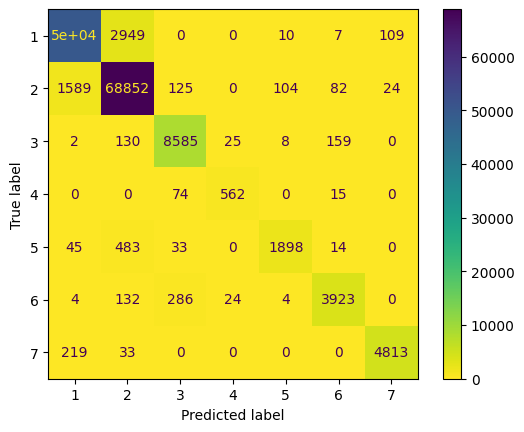

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [68]:
title = "Confusion Matrix for muti-class classification"
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, cmap = 'viridis_r')
plt.show()
print(model.get_params())

In [4]:
#Ray tune on one vm
import ray
from ray import tune

# ray.init(num_gpus=0)
#Env var
RAY_memory_monitor_refresh_ms = 0
RAY_memory_usage_threshold = 0.4
 
def objective(step, max_depth, n_estimators, ccp_alpha):
    x,y = fetch_covtype(return_X_y=True)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True)
    model = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, ccp_alpha = ccp_alpha) #, n_jobs = -1)
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    return np.mean(np.mean(prediction != y_test)*100)

# def tune_func(config):
#     tune.utils.wait_for_gpu()
#     training_function()

def training_function(config):
    # Hyperparameters
    max_depth, n_estimators, ccp_alpha = config["max_depth"], config["n_estimators"], config["ccp_alpha"]
#     tune.utils.wait_for_gpu()
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, max_depth, n_estimators, ccp_alpha)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)
 
analysis = tune.run(
   training_function,
   config={
       "max_depth": tune.grid_search([1000,3000,5000,7000]),
       "n_estimators": tune.grid_search([20,40,60,80,100]),
       "ccp_alpha": tune.grid_search([0])}
#    },
#        resources_per_trial = {"cpu": 3}
   )
 
print("Best config: ", analysis.get_best_config(
   metric="mean_loss", mode="min"))
 
# Get a dataframe for analyzing trial results.
df = analysis.results_df

# ray.shutdown()

2023-05-10 09:51:24,314	WARNING tune.py:184 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-05-10 09:51:25,350	ERROR tune.py:941 -- Trials did not complete: [training_function_fb53e_00000, training_function_fb53e_00001, training_function_fb53e_00002, training_function_fb53e_00003, training_function_fb53e_00004, training_function_fb53e_00005, training_function_fb53e_00006, training_function_fb53e_00007, training_function_fb53e_00008, training_function_fb53e_00009, training_function_fb53e_00010, training_function_fb53e_00011, training_function_fb53e_00012, training_function_fb53e_00013, training_function_fb53e_00014, training_function_fb53e_00015]
2023-05-10 09:51:25,352	INFO tune.py:945 -- Total run time: 105.54 seconds (105.50 seconds for the tuning loop).
2023-05-10 09:51:25,353	WARNING tune.py:954 -- Experiment has been interrupted, but t

Best config:  None


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

/tmp/ipykernel_132785/2284580335.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


2023-05-10 09:52:52,800	WARNING worker.py:1986 -- The autoscaler failed with the following error:
Terminated with signal 15
  File "/home/ubuntu/.local/lib/python3.10/site-packages/ray/autoscaler/_private/monitor.py", line 674, in <module>
    monitor.run()
  File "/home/ubuntu/.local/lib/python3.10/site-packages/ray/autoscaler/_private/monitor.py", line 550, in run
    self._run()
  File "/home/ubuntu/.local/lib/python3.10/site-packages/ray/autoscaler/_private/monitor.py", line 454, in _run
    time.sleep(AUTOSCALER_UPDATE_INTERVAL_S)



In [ ]:
import torch
alpha = 0.01
w = torch.tensor([1,0],requires_grad = True)

for i in range(0,1000):
    J_w = J(w)
    grad = torch.autograd.grad(J_w,w)[0]
    w = w+alpha* grad